In [67]:
from tensorflow.keras.layers import LSTM, Dense, Masking, BatchNormalization, Attention
from tensorflow.keras.regularizers import l2
import joblib
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, Flatten, Input
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.ticker as ticker
import seaborn as sns

#### Helper Modules for loading + pre-processing data, filling in erroneous values, generating data for training, and defining the LSTM model

In [68]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df.sort_values(['game_id', 'team', 'player', 'round_num', 'seconds'])
    df['won'] = df['won'].replace({True: 1, False: 0})
    df["agent_name"] = df["agent_name"].astype("category").cat.codes
    df["map_name"] = df["map_name"].astype("category").cat.codes
    df["side"] = df["side"].astype("category").cat.codes
    df["spike_event"] = df["spike_event"].astype("category").cat.codes
    df["spike_planted"] = df["spike_planted"].astype("category").cat.codes
    return df
    
def preprocess_data(df, scaler=None, validation=False):
    df['cs_round_normalized'] = (df['combat_score_round'] - df['combat_score_round'].min()) / (df['combat_score_round'].max() - df['combat_score_round'].min())
    target_column = 'cs_round_normalized'  # was combat_score_round
    feature_columns = df.columns.difference(["game_id", "player", "game_version", "game_datetime", "inventory", "team_id", "attacking_team",
                                             "event_num", "event_time", "round_start_time",
                                             "clock_time", 'account_id', 'agent_id', 'team', "opponent_team", "spike_diffused", "teamId_value",
                                             "ability1_temp_charges", "ability1_max_charges", "ultimate_temp_charges", "ultimate_max_charges",
                                             "ability2_max_charges", "ability2_temp_charges", "grenade_temp_charges", "grenade_max_charges",
                                             "money","combat_score_total","damage_dealt", "damage_taken", "combat_score_round", "cs_round_normalized",
                                             "kills","deaths","assists","won"])
                                             #"opponent_kill_c", "opponent_death_c", "opponent_damage_dealt_c", "opponent_damage_taken_c","player_damage_dealt_c", "player_damage_taken_c",
                                             #"player_kill_c", "player_death_c", "kill_change", "death_change",
                                             #"damage_dealt_c", "damage_taken_c", "kill_c", "death_c","is_alive"
                                             #"spike_planted","team_inventory_value", "opponent_team_inventory_value",
                                             #"our_team_health",  "opponent_team_health", "opponent_team_alive", "our_team_alive",
                                             # "x", "y", "z", "velocity_x", "velocity_y", "velocity_z", "view_x", "view_y", "view_z",
    df.loc[:,feature_columns] = check_and_handle_nan_inf(df.loc[:,feature_columns])
    df.loc[:,target_column] = check_and_handle_nan_inf(df.loc[:,target_column])
    if not validation:
        scaler = StandardScaler()
        df.loc[:,feature_columns] = scaler.fit_transform(df.loc[:,feature_columns])
    else:  # validation set
        df.loc[:,feature_columns] = scaler.transform(df.loc[:,feature_columns])

    return df, feature_columns, target_column, scaler

def check_and_handle_nan_inf(X):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        print("X_train contains NaNs or infinite values. Fixing...")
        X[np.isnan(X)] = np.nanmean(X)
        X.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)  # Replace with max value of the same dtype
        print("NaNs and infinite values fixed.")
    else:
        print("No NaNs or infinite values found.")
    return X

def generate_samples(df, feature_columns, target_column):
    grouped = df.groupby(['game_id', 'player'])
    player_game_samples = []
    target_game_samples = []

    for (game_id, player), player_game_df in grouped:
        player_game_samples.append([g[feature_columns].reset_index(drop=True).values for _, g in player_game_df.groupby('round_num')])
        target_game_samples.append(np.array(player_game_df.groupby('round_num')[target_column].last()))
    

    return player_game_samples, target_game_samples

def generator(player_game_samples, target_game_samples):
    # for player_data, player_targets in zip(player_game_samples, target_game_samples):
    for player_data, player_targets in zip(player_game_samples, target_game_samples):
        max_timesteps = max(round_data.shape[0] for round_data in player_data)
        padded_rounds = [np.pad(round_data, ((0, max_timesteps - round_data.shape[0]), (0, 0)), 'constant', constant_values=-999)
                         for round_data in player_data]
        stacked_rounds = np.stack(padded_rounds, axis=0)

        yield stacked_rounds, player_targets

def build_model(num_features):
    model = Sequential([
        Input(shape=(None, num_features)),  # Input layer with shape specification
        Masking(mask_value=-999), # Handles variable timesteps
        LSTM(16, return_sequences=True),
        #BatchNormalization(),
        #Dropout(0.3),  # Dropout to prevent overfitting
        LSTM(8, return_sequences=False),
        #BatchNormalization(),
        #LSTM(2, return_sequences=False),
        #BatchNormalization(),
        #Dropout(0.3),  # Dropout to prevent overfitting
        #Dense(4),
        Dense(1, activation='linear')  # Linear activation for continuous predictions
    ])
    
    # Compile model with custom loss function
    model.compile(
        #optimizer='adam',
        optimizer=Adam(learning_rate=0.0001),
        loss = 'huber',
        metrics=[
            'mse',
            'mae'
        ]
    )
    return model

def plot_metrics(history, target_type):
    if target_type == 'binary':
        fig, ax1 = plt.subplots()
        ax1.plot(history.history['accuracy'], label='Accuracy (training data)', color='b')
        ax1.plot(history.history['auc'], label='AUC (training data)', color='g')
        ax2 = ax1.twinx()
        ax2.plot(history.history['loss'], label='Loss (training data)', color='r')
        plt.title('Model Performance')
        ax1.set_ylabel('Metric Value')
        ax2.set_ylabel('Loss Value')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc="lower left")
        ax2.legend(loc="upper left")
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.plot(history.history['val_accuracy'], label='Accuracy (validation data)', color='b')
        ax1.plot(history.history['val_auc'], label='AUC (validation data)', color='g')
        ax2 = ax1.twinx()
        ax2.plot(history.history['val_loss'], label='Loss (validation data)', color='r')
        plt.title('Model Performance')
        ax1.set_ylabel('Metric Value')
        ax2.set_ylabel('Loss Value')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc="lower left")
        ax2.legend(loc="upper left")
        plt.show()
    elif target_type=='continuous':
        fig, ax1 = plt.subplots()
        ax1.plot(history.history['mae'], label='MAE (training data)', color='b')
        ax1.plot(history.history['mse'], label='MSE (training data)', color='g')
        ax2 = ax1.twinx()
        ax2.plot(history.history['loss'], label='Loss (training data)', color='r')
        plt.title('Model Performance')
        ax1.set_ylabel('Metric Value')
        ax2.set_ylabel('Loss Value')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc="lower left")
        ax2.legend(loc="upper left")
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.plot(history.history['val_mae'], label='MAE (validation data)', color='b')
        ax1.plot(history.history['val_mse'], label='MSE (validation data)', color='g')
        ax2 = ax1.twinx()
        ax2.plot(history.history['val_loss'], label='Loss (validation data)', color='r')
        plt.title('Model Performance')
        ax1.set_ylabel('Metric Value')
        ax2.set_ylabel('Loss Value')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc="lower left")
        ax2.legend(loc="upper left")
        plt.show()

def save_model(model, model_path):
    model.save(model_path)
    print(f"Model saved to {model_path}")

def load_model(model_path):
    return tf.keras.models.load_model(model_path)

#### Generating training and validation dataset

In [69]:


# Main Execution
file_path = "./eg_train.csv"

df = load_data(file_path)
df, feature_columns, target_column, scaler_plotting = preprocess_data(df)
# Define the output signature for both training and validation datasets
output_signatures = (
    tf.TensorSpec(shape=(None, None, len(feature_columns)), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Assuming targets are 1D; adjust as necessary.
)

player_game_samples, target_game_samples = generate_samples(df, feature_columns, target_column)

# Create the dataset using the updated from_generator syntax
dataset = tf.data.Dataset.from_generator(
    lambda: generator(player_game_samples, target_game_samples),
    output_signature=output_signatures
)

batched_dataset = dataset

# Create validation dataset using EG 15-games
val_file_path = "./eg_test.csv"
val_df = load_data(val_file_path)
val_df, val_feature_columns, val_target_column, _ = preprocess_data(val_df, scaler_plotting, validation=True)
val_player_game_samples, val_target_game_samples = generate_samples(val_df, val_feature_columns, val_target_column)

# Create the dataset using the updated from_generator syntax
val_dataset = tf.data.Dataset.from_generator(
    lambda: generator(val_player_game_samples, val_target_game_samples),
    output_signature=output_signatures
)
# ----------------------------------------------

X_train contains NaNs or infinite values. Fixing...
NaNs and infinite values fixed.
No NaNs or infinite values found.
X_train contains NaNs or infinite values. Fixing...
NaNs and infinite values fixed.
No NaNs or infinite values found.


#### Compile the model and train on generated data

In [70]:
model = build_model(len(feature_columns))
history = model.fit(batched_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
    650/Unknown 20s 26ms/step - loss: 0.0658 - mae: 0.2773 - mse: 0.1316

C:\Users\soham\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


650/650 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0657 - mae: 0.2771 - mse: 0.1315 - val_loss: 0.0144 - val_mae: 0.1228 - val_mse: 0.0287
Epoch 2/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0062 - mae: 0.0833 - mse: 0.0124 - val_loss: 0.0120 - val_mae: 0.1092 - val_mse: 0.0241
Epoch 3/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0039 - mae: 0.0668 - mse: 0.0079 - val_loss: 0.0113 - val_mae: 0.1046 - val_mse: 0.0227
Epoch 4/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0031 - mae: 0.0602 - mse: 0.0063 - val_loss: 0.0110 - val_mae: 0.1022 - val_mse: 0.0220
Epoch 5/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0027 - mae: 0.0567 - mse: 0.0055 - val_loss: 0.0107 - val_mae: 0.1006 - val_mse: 0.0215
Epoch 6/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0025 - mae: 0.0542 - mse: 0.0050 - val_loss: 0.0106 - val_mae: 0.0992 - val_mse: 0.0211
Epoch 7/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 0.0023 - mae: 0.0524 - mse: 0.0046 - 

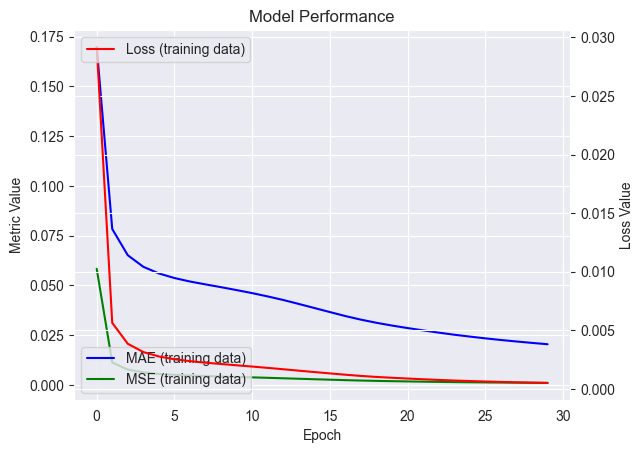

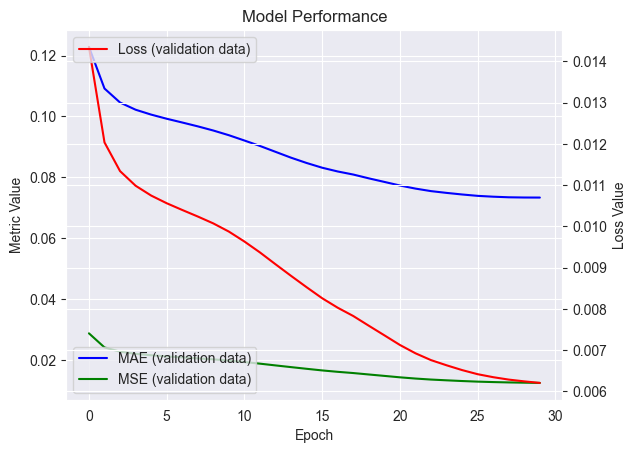

Model saved to valorant_lstm_model_combatscore_target.keras


In [71]:
plot_metrics(history, target_type='continuous')

# model save path
model_path = "valorant_lstm_model_combatscore_target.keras"
save_model(model, model_path)

In [72]:
joblib.dump(scaler_plotting, 'scaler_combatscore_target.pkl')

['scaler_combatscore_target.pkl']

#### Helper module to prepare validation data for scoring (inference)

In [73]:
def infer(model, new_data, feature_columns, target_column, scaler):
    new_data['cs_round_normalized'] = (new_data['combat_score_round'] - new_data['combat_score_round'].min()) / (new_data['combat_score_round'].max() - new_data['combat_score_round'].min())
    new_data.loc[:,feature_columns] = check_and_handle_nan_inf(new_data.loc[:,feature_columns])
    new_data.loc[:,feature_columns] = scaler.transform(new_data.loc[:,feature_columns])
    player_game_samples, target_game_samples = generate_samples(new_data, feature_columns, target_column)
    
    print("Player game samples:", len(player_game_samples))
    
    predictions = []
    for sample, _ in generator(player_game_samples, target_game_samples):
        print("Batch shape:", sample.shape)
        pred = model.predict(sample)
        print("pred", pred)
        predictions.append(pred)
    
    print("Predictions length:", len(predictions))
    
    results = []
    grouped_keys = list(new_data.groupby(['game_id', 'player']).groups.keys())
    print("Grouped keys length:", len(grouped_keys))
    
    for i, (game_id, player) in enumerate(grouped_keys):
        if i >= len(predictions):
            print(f"Warning: Not enough predictions for game_id {game_id} and player {player}")
            continue
        for round_num, (pred_score, target_score) in enumerate(zip(predictions[i], target_game_samples[i])):
            results.append((game_id, player, round_num + 1, pred_score[0], target_score))
            print(f"Game ID: {game_id}, Player: {player}, Round Number: {round_num + 1}, Prediction Score: {pred_score[0]}, Target Score: {target_score}")
    
    results_df = pd.DataFrame(results, columns=['Gameid', 'Playername', 'round_number', 'EGR', 'Target'])
    return results_df



In [74]:
# Inference on new data
new_data_file_path = "./eg_test.csv"
new_data = load_data(new_data_file_path)
#results_df = infer(load_model(model_path), new_data, feature_columns, StandardScaler().fit(df[feature_columns]))
results_df = infer(model, new_data, feature_columns, target_column, scaler_plotting)
print("Inference results dataframe:")
print(results_df)

X_train contains NaNs or infinite values. Fixing...
NaNs and infinite values fixed.
Player game samples: 150
Batch shape: (23, 102, 56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
pred [[ 0.01209493]
 [ 0.01322583]
 [ 0.0027539 ]
 [ 0.00851743]
 [ 0.04879655]
 [ 0.01980673]
 [ 0.01629767]
 [ 0.19014205]
 [ 0.02033945]
 [ 0.01495108]
 [ 0.17553401]
 [ 0.00411585]
 [ 0.09728013]
 [ 0.06938338]
 [ 0.00990624]
 [ 0.05694361]
 [ 0.06827816]
 [ 0.17386799]
 [ 0.01764727]
 [ 0.02030977]
 [ 0.01559207]
 [-0.00197899]
 [ 0.05572647]]
Batch shape: (23, 102, 56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pred [[0.02111783]
 [0.09219036]
 [0.30900407]
 [0.01375776]
 [0.11541481]
 [0.06742942]
 [0.12517616]
 [0.0209222 ]
 [0.00150458]
 [0.12821999]
 [0.04182044]
 [0.00984538]
 [0.10921991]
 [0.04439232]
 [0.02550347]
 [0.03415665]
 [0.06060355]
 [0.01479368]
 [0.21814732]
 [0.05664083]
 [0.21530512]
 [0.01361919]
 [0.08551725]]
Batch shape: (23, 102, 56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
pred [[0.1683585

In [75]:
eg_data=pd.read_csv(new_data_file_path)
rf=results_df.rename(columns={"Gameid":"game_id","Playername":"player","round_number":"round_num"})[["game_id"	,"player","round_num","EGR","Target"]]
merged_table = pd.merge(eg_data, rf, on=['game_id', 'player', 'round_num'])

In [76]:
merged_table.to_csv("egr_eg_results_combatscore_target.csv",index=False)

#### Visualize distribution of predictions on validation set, along with supporting plots to identify correlations

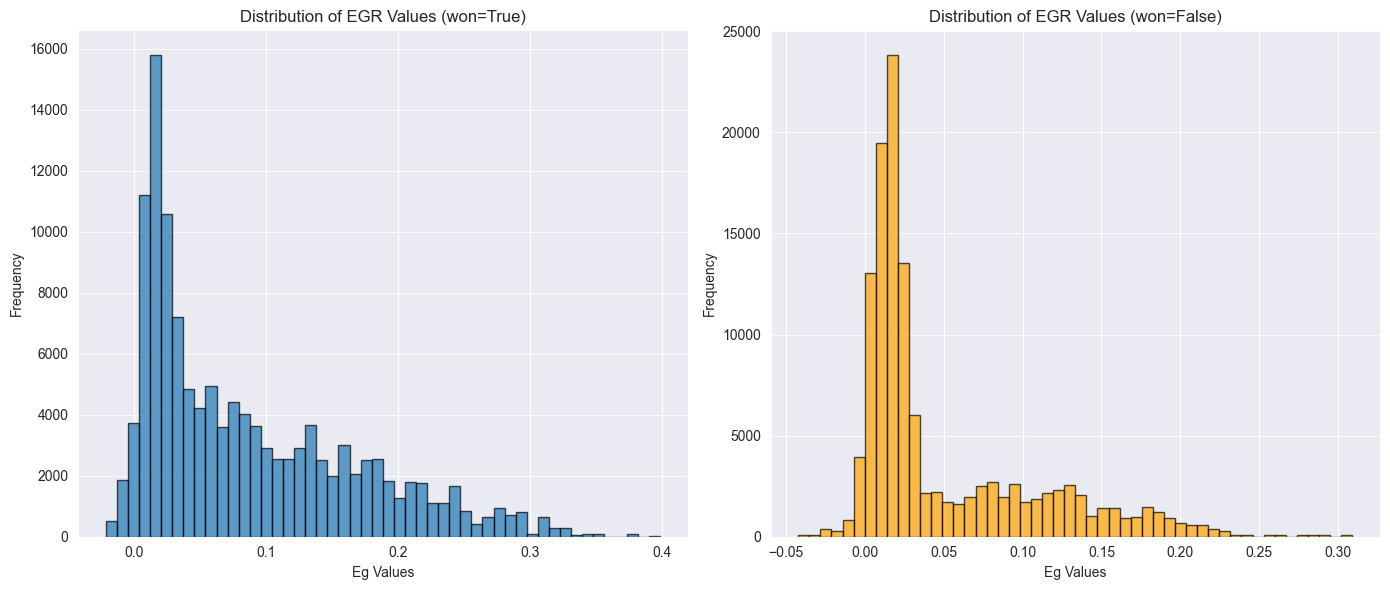

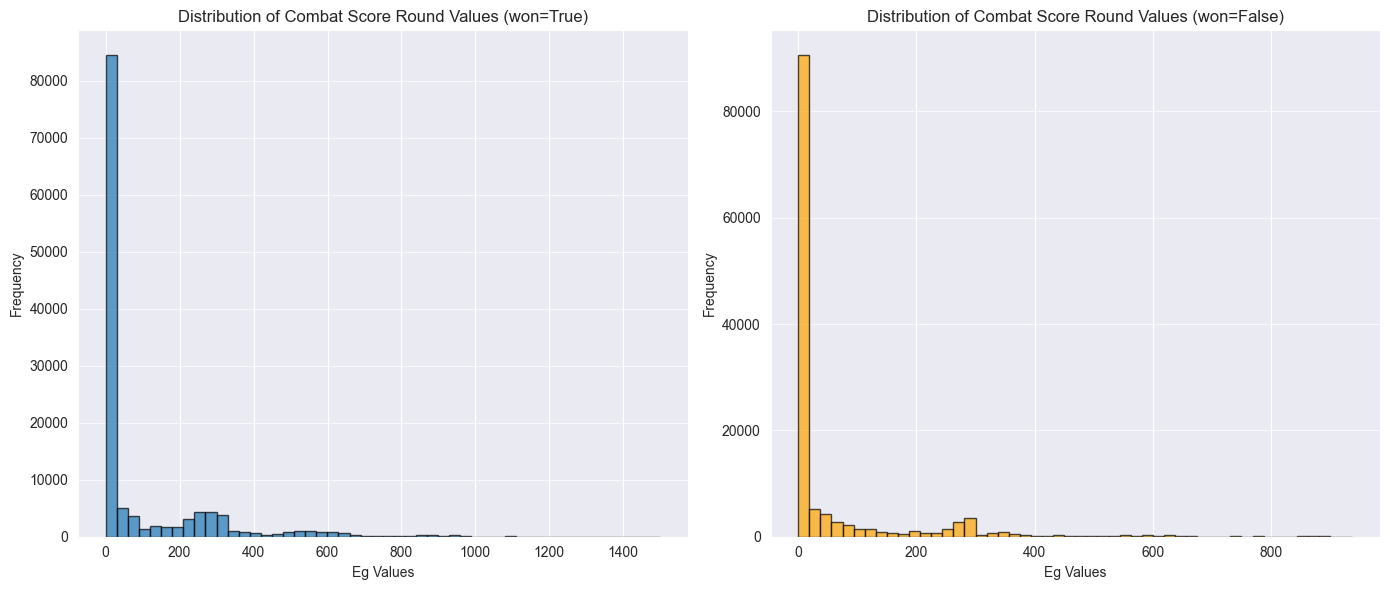

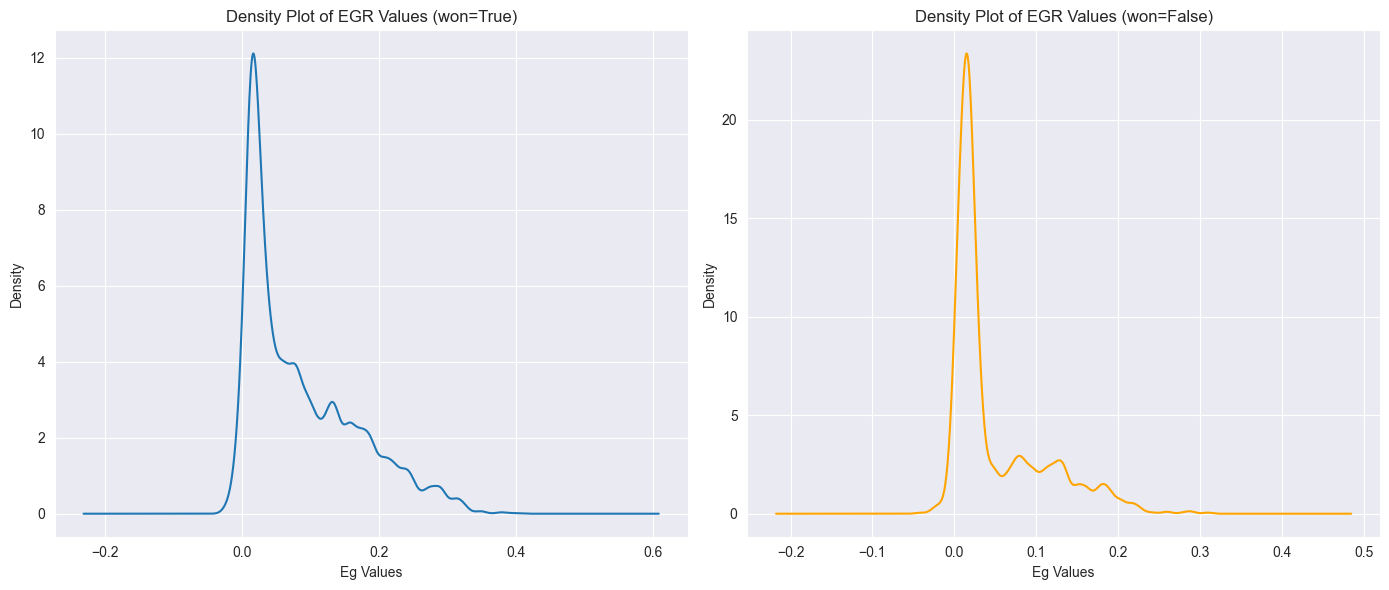

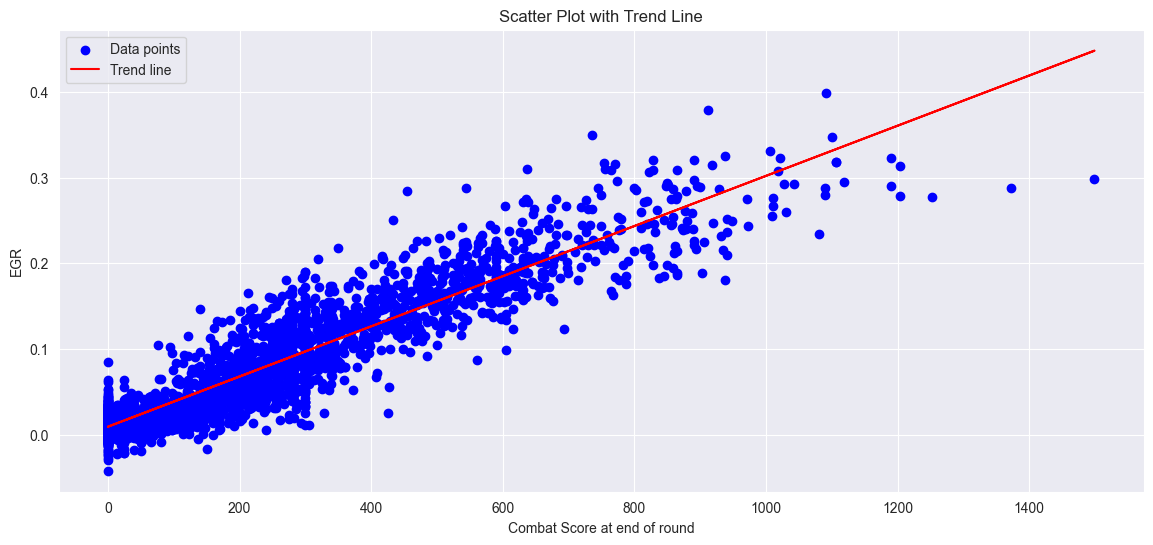

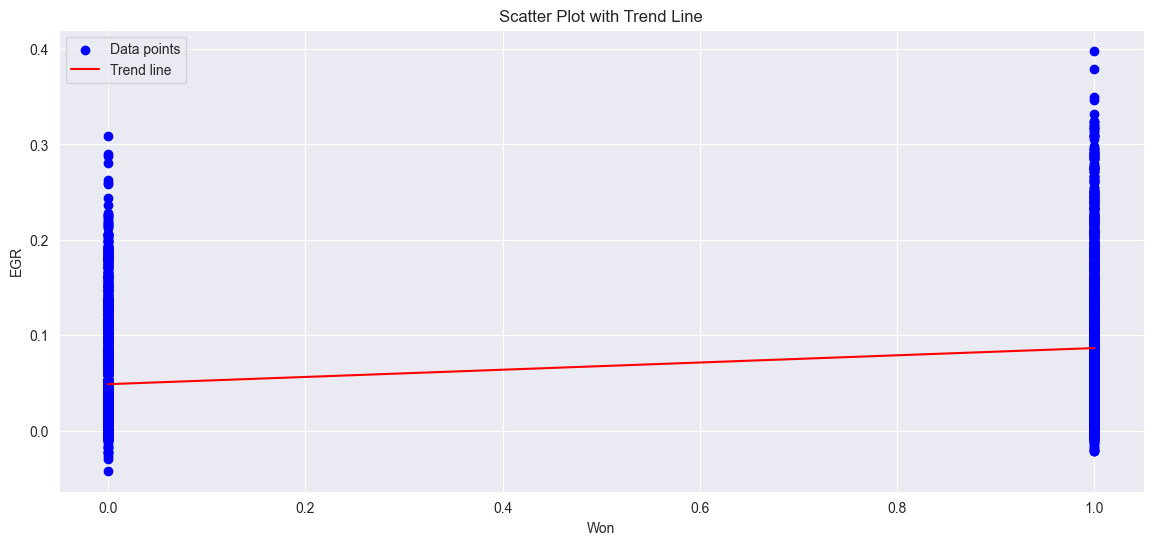

In [77]:
# visualization of results
df = merged_table 
# Create histograms for both True and False values in 'won'
plt.figure(figsize=(14, 6))

# Histogram for True
plt.subplot(1, 2, 1)
plt.hist(df[df['won'] == True]['EGR'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of EGR Values (won=True)')
plt.xlabel('Eg Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Histogram for False
plt.subplot(1, 2, 2)
plt.hist(df[df['won'] == False]['EGR'], bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Distribution of EGR Values (won=False)')
plt.xlabel('Eg Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the plots
plt.tight_layout()
plt.show()
#----
# Histogram for True
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(df[df['won'] == True]['combat_score_round'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Combat Score Round Values (won=True)')
plt.xlabel('Eg Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Histogram for False
plt.subplot(1, 2, 2)
plt.hist(df[df['won'] == False]['combat_score_round'], bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Distribution of Combat Score Round Values (won=False)')
plt.xlabel('Eg Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the plots
plt.tight_layout()
plt.show()
#-----

# Optionally, create Kernel Density Plots for both True and False values
plt.figure(figsize=(14, 6))

# KDE for True
plt.subplot(1, 2, 1)
df[df['won'] == True]['EGR'].plot(kind='kde', label='won=True')
plt.title('Density Plot of EGR Values (won=True)')
plt.xlabel('Eg Values')
plt.ylabel('Density')

# KDE for False
plt.subplot(1, 2, 2)
df[df['won'] == False]['EGR'].plot(kind='kde', color='orange', label='won=False')
plt.title('Density Plot of EGR Values (won=False)')
plt.xlabel('Eg Values')
plt.ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()

#---
# Plotting EGR vs Combat Score (per round)
plt.figure(figsize=(14, 6))
df_egr_cs = df.groupby(['game_id','round_num','player']).last()[['EGR','combat_score_round','won']]
plt.scatter(df_egr_cs['combat_score_round'], df_egr_cs['EGR'], color='blue', label='Data points')  # Scatter plot
plt.xlabel('Combat Score at end of round')
plt.ylabel('EGR')
plt.title('Scatter Plot with Trend Line')

# Trend line
slope, intercept = np.polyfit(df_egr_cs['combat_score_round'], df_egr_cs['EGR'], 1)
trendline = slope * df_egr_cs['combat_score_round'] + intercept
plt.plot(df_egr_cs['combat_score_round'], trendline, color='red', label='Trend line')  # Trend line

plt.legend()
plt.show()
#---
#---
# Plotting EGR vs Won (1 or 0) -- doesn't make as much sense since we should look at sum(EGR) vs won
plt.figure(figsize=(14, 6))
plt.scatter(df_egr_cs['won'], df_egr_cs['EGR'], color='blue', label='Data points')  # Scatter plot
plt.xlabel('Won')
plt.ylabel('EGR')
plt.title('Scatter Plot with Trend Line')

# Trend line
slope, intercept = np.polyfit(df_egr_cs['won'], df_egr_cs['EGR'], 1)
trendline = slope * df_egr_cs['won'] + intercept
plt.plot(df_egr_cs['won'], trendline, color='red', label='Trend line')  # Trend line

plt.legend()
plt.show()

In [78]:
merged_table.head()

,round_num,game_id,player,inventory_value,event_num,game_version,game_datetime,round_start_time,event_time,seconds,...,opponent_kill_c,opponent_death_c,opponent_damage_dealt_c,opponent_damage_taken_c,spike_diffused,team_id,won,map_name,EGR,Target
0,1,950007b5-1f27-4f5c-864d-34f5c97f2d28,Apoth,500.0,881.0,08.07.00.2460481,2024-04-28T23:48:06.586Z,586.633,586.994,0.361,...,0.0,0.0,0.0,0.0,NaN,281,False,ascent,0.01521,0.0
1,1,950007b5-1f27-4f5c-864d-34f5c97f2d28,Apoth,500.0,886.0,08.07.00.2460481,2024-04-28T23:48:06.586Z,586.633,587.993,1.360,...,0.0,0.0,0.0,0.0,NaN,281,False,ascent,0.01521,0.0
2,1,950007b5-1f27-4f5c-864d-34f5c97f2d28,Apoth,500.0,893.0,08.07.00.2460481,2024-04-28T23:48:06.586Z,586.633,588.989,2.356,...,0.0,0.0,0.0,0.0,NaN,281,False,ascent,0.01521,0.0
3,1,950007b5-1f27-4f5c-864d-34f5c97f2d28,Apoth,500.0,895.0,08.07.00.2460481,2024-04-28T23:48:06.586Z,586.633,590.003,3.370,...,0.0,0.0,0.0,0.0,NaN,281,False,ascent,0.01521,0.0
4,1,950007b5-1f27-4f5c-864d-34f5c97f2d28,Apoth,500.0,898.0,08.07.00.2460481,2024-04-28T23:48:06.586Z,586.633,590.993,4.360,...,0.0,0.0,0.0,0.0,NaN,281,False,ascent,0.01521,0.0


##### **Goal**: compare sums of each team's EGR (per round)-- team with higher score per round "wins" the round"; will comapre 

In [79]:
##### **player_round_df**: take input dataset and create a df that has one group per game-team-player-round
##### **summary_df**: take player_round df and create a df that has one row per game-team-round (to track EGR per team per round)
summary_df = pd.DataFrame()
player_round_df = (merged_table.reset_index().groupby(['game_id', 'team', 'player', 'round_num'])[['game_datetime','agent_name', 'EGR', 'won']].last()).sort_values('game_datetime').reset_index()
summary_df = player_round_df.groupby(['game_id', 'team', 'round_num']).agg(
    team_total_EGR=('EGR', 'sum'),
    team_actual_won=('won', 'last')
).reset_index()

In [80]:
# Create a summary df that will have the team and opp_team EGR values i nthe same row
# Create a copy for the merge operation
opp_df = summary_df.copy()

# Rename the columns for clarity when merging
opp_df.rename(columns={'team_total_EGR': 'opp_total_EGR', 'team': 'opp_team', 'team_actual_won': 'opp_actual_won'}, inplace=True)

# Merge the DataFrame on 'game_id' and 'round_num' to align opposing teams
summary_df = summary_df.merge(opp_df, how='left', left_on=['game_id', 'round_num'], right_on=['game_id', 'round_num'])

# Filter out the rows where the team is the same (not needed in this context)
summary_df = summary_df[summary_df['team'] != summary_df['opp_team']]

# Drop the 'opp_team' column as it's not necessary for the final DataFrame
summary_df.drop(['opp_team', 'opp_actual_won'], axis=1, inplace=True)

# Reorder or sort the DataFrame if necessary
summary_df.sort_values(by=['game_id', 'round_num', 'team'], inplace=True)
summary_df.reset_index(drop=True, inplace=True)
summary_df['team_actual_won'] = summary_df['team_actual_won'].astype(int)
summary_df['team_pred_won'] = np.where(summary_df['team_total_EGR'] > summary_df['opp_total_EGR'], 1, 0)

In [81]:
# Calculate the number of matching values between derived round win calculation and actual round wins
matches = (summary_df['team_pred_won'] == summary_df['team_actual_won'])

# Calculate the percentage of matches
percentage_match = matches.mean() * 100
print(str(percentage_match) + '% Accuracy on EG validation dataset (using sum of EGRs per team to decide round winner)')

92.12121212121212% Accuracy on EG validation dataset (using sum of EGRs per team to decide round winner)


In [82]:
merged_table['pred_won'] = np.where(merged_table['EGR'] < 0.5 , 0, 1)
# Calculate the number of matching values
matches = (merged_table['pred_won'] == merged_table['won'])

# Calculate the percentage of matches
percentage_match = matches.mean() * 100
print(str(percentage_match) + '% Accuracy on EG validation dataset (using naive 0.5 score threshold)')

50.0% Accuracy on EG validation dataset (using naive 0.5 score threshold)


#### Create some plots to sanity check EGR progression **through a specific game** against match film

In [83]:
# Prepare DataFrame with necessary details
# Assume 'agent_name' is properly formatted and the DataFrame 'player_round_df' is correctly initialized
# VLR Rating Ranks from vlr.gg for this match: https://www.vlr.gg/295617/g2-esports-vs-evil-geniuses-champions-tour-2024-americas-kickoff-winners-c/?game=153759&tab=overview
vlr_ratings = {
    'supamen': 1,
    'leaf': 2,
    'Apoth': 3,
    'JonahP': 4,
    'Derrek': 5,
    'trent': 6,
    'valyn': 7,
    'NaturE': 8,
    'JAWGEMO': 9,
    'neT': 10
}

# Scaling EGR values to be between 0 to 100
player_round_df['EGR'] = 100 * player_round_df['EGR']

# Filtering data for specific game
game_id = '9eb96458-82f2-4a25-b53c-c9bee13df754'
df_game = player_round_df[player_round_df['game_id'] == game_id].sort_values(['game_id','team','player','round_num'])

# Calculate average EGR and prepare for plotting
player_avg_egr = df_game.groupby('player')['EGR'].mean().sort_values(ascending=False)

# Identify teams
teams = df_game['team'].unique()

o
o
s
s
D
D
^
^
v
v


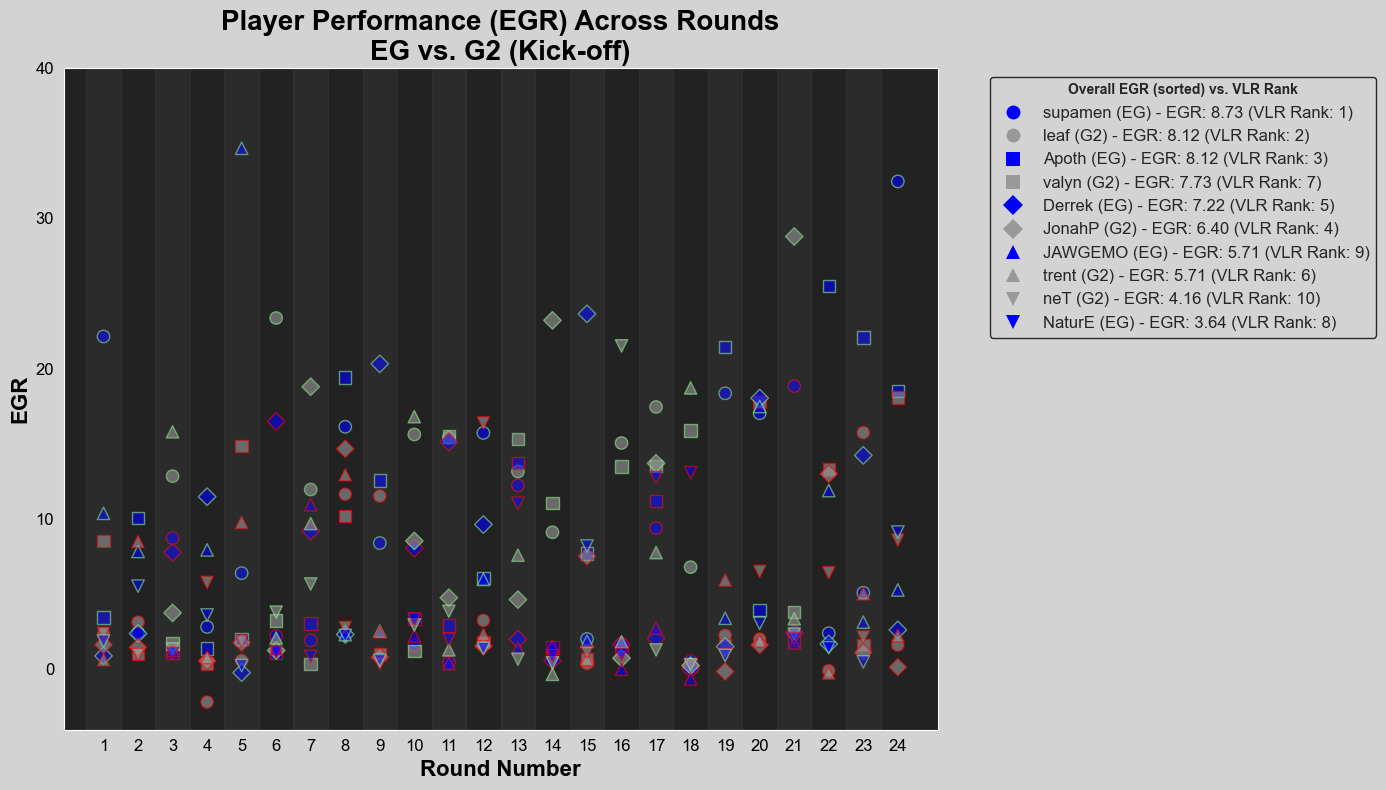

In [84]:
# Assign colors for each team
team_colors = {
    teams[0]: 'blue',  # Blue for Team A
    teams[1]: '#999999'  # Gray for Team B
}

# Define unique markers for each player within a team
markers = ['o', 's', 'D', '^', 'v']
team_markers = {}

fig, ax = plt.subplots(figsize=(14, 8), facecolor='lightgray')
ax.set_facecolor('#222222')  # Dark gray background

legend_handles = {}  # Dictionary to keep track of unique legend handles
max_round_num = df_game['round_num'].max() 

# Plot each player's EGR across rounds
for idx, player_id in enumerate(player_avg_egr.index):
    player_data = df_game[df_game['player'] == player_id]
    team = player_data['team'].iloc[0]

    # Select color and marker based on team and player
    color = team_colors[team]
    # Initialize team marker list if it doesn't exist
    if team not in team_markers:
        team_markers[team] = markers.copy()  # Make a copy of markers list

    # Select a unique marker for each player within the team
    marker = team_markers[team].pop(0)  # Get and remove the first marker from the list
    print(marker)
    edge_colors = ['lightgreen' if won else 'red' for won in player_data['won']]

    # Create scatter plot for player
    scatter = ax.scatter(player_data['round_num'], player_data['EGR'],
                         color=color, marker=marker, edgecolors=edge_colors,
                         s=80, alpha=0.6)

    # Prepare a proxy artist with default edge color for the legend
    if player_id not in legend_handles:
        # Create a proxy artist with no edge color
        proxy_artist = plt.Line2D([], [], color=color, marker=marker, linestyle='None',
                                  markersize=10, markeredgewidth=0, label=f"{player_id} ({team}) - EGR: {player_avg_egr[player_id]:.2f} (VLR Rank: {vlr_ratings[player_id]})")
        legend_handles[player_id] = proxy_artist

# Add shaded areas for alternate rounds
for i in range(1, max_round_num + 1, 2):  # Starting from 1, apply to every second round
    ax.axvspan(i-.5, i+.5, color='grey', alpha=0.1)  # Adjust alpha for lighter or darker shade

# Set legend with custom handles
ax.legend(handles=list(legend_handles.values()), title="Overall EGR (sorted) vs. VLR Rank", loc='upper left', fontsize=12,
          frameon=True, bbox_to_anchor=(1.05, 1), facecolor='lightgray', edgecolor='black')
ax.get_legend().get_title().set_fontweight('bold')

# Styling and labeling
plt.title('Player Performance (EGR) Across Rounds\nEG vs. G2 (Kick-off)', fontsize=20, fontweight='bold', color='black')
plt.xlabel('Round Number', fontsize=16, fontweight='bold', color='black')
plt.ylabel('EGR', fontsize=16, fontweight='bold', color='black')
plt.xticks(ticks=np.arange(1, 25, 1), fontsize=12, color='black')
plt.yticks(np.arange(0, 50, 10), fontsize=12, color='black')
plt.grid(False)

plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.show()


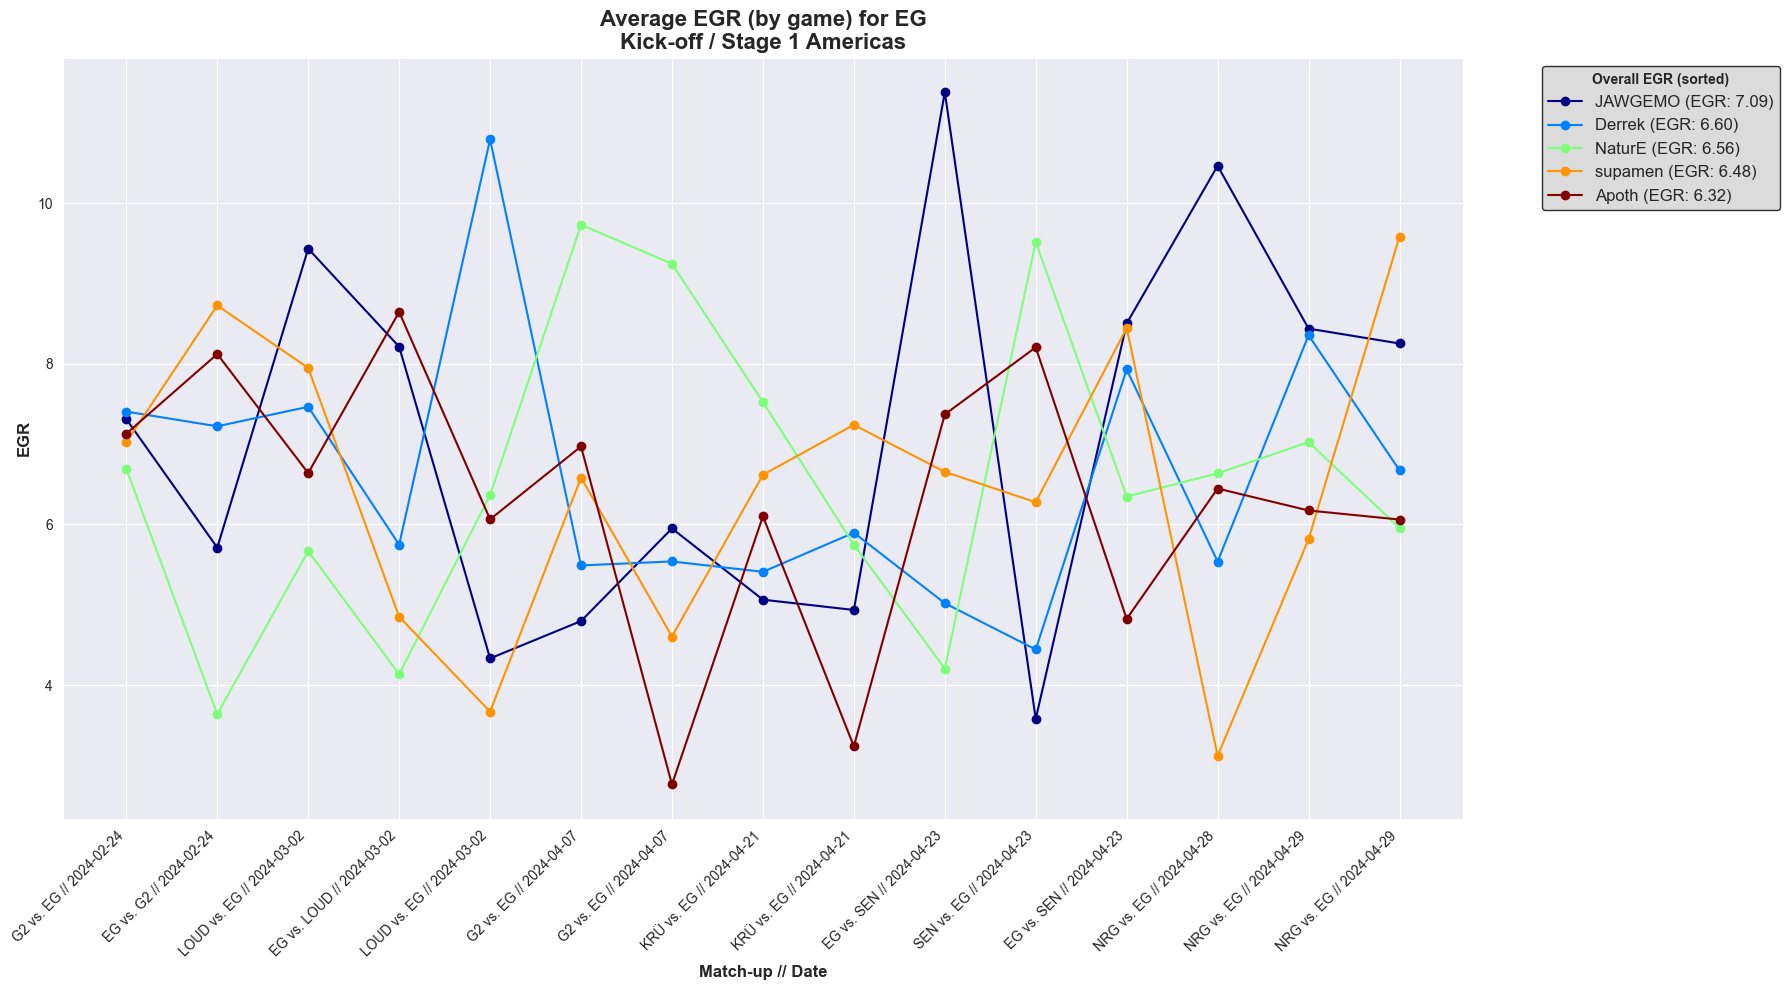

In [85]:
# Set the Seaborn style
sns.set_style("darkgrid")

# Convert game_datetime from string to datetime if it's not already
player_round_df['game_datetime'] = pd.to_datetime(player_round_df['game_datetime'])
player_round_df['date'] = player_round_df['game_datetime'].dt.date

# Filter the DataFrame for EG players
players = ['supamen', 'Apoth', 'Derrek', 'JAWGEMO', 'NaturE']
filtered_df = player_round_df[player_round_df['player'].isin(players)]

# Calculate the average EGR per game per player
average_egr = filtered_df.groupby(['game_id', 'player'])['EGR'].mean().reset_index()

# Get game dates and team information
game_dates = player_round_df[['game_id', 'game_datetime']].drop_duplicates()
teams_info = player_round_df.groupby(['game_id', 'game_datetime', 'date'])['team'].unique().apply(lambda x: ' vs. '.join(x)).reset_index()

# Add a game number for each day
teams_info['game_number'] = teams_info.groupby('date').cumcount() + 1
teams_info['team_info'] = teams_info.apply(lambda x: f"{x['team']} - Game {x['game_number']} - {x['date']}", axis=1)

average_egr = average_egr.merge(game_dates, on='game_id')
average_egr = average_egr.merge(teams_info[['game_id', 'team_info']], on='game_id')

# Sort the data by game datetime
average_egr.sort_values(by='game_datetime', inplace=True)

# Calculate overall average EGR for each player
overall_egr = average_egr.groupby('player')['EGR'].mean().sort_values(ascending=False).reset_index()

# Prepare for plotting
fig, ax = plt.subplots(figsize=(18, 10))

# Colors array based on the sorted order
colors = plt.cm.jet(np.linspace(0, 1, len(overall_egr)))

# Plot each player's data, ordered by their overall average EGR
for i, row in overall_egr.iterrows():
    player = row['player']
    player_data = average_egr[average_egr['player'] == player]
    # Plot with label including the overall average EGR rounded to 2 decimal places
    ax.plot(player_data['game_id'], player_data['EGR'], marker='o', linestyle='-', 
            label=f"{player} (EGR: {row['EGR']:.2f})", color=colors[i])

# Set x-ticks and labels
ax.set_xticks(teams_info['game_id'])
ax.set_xticklabels(teams_info['team'] + ' // ' + teams_info['date'].astype(str), rotation=45, ha='right')
#plt.xticks(rotation=45, ha='right')

# Legend sorted by average EGR
handles, labels = ax.get_legend_handles_labels()
# Sort both handles and labels based on the sorted order we already established in overall_egr
handles = [handles[i] for i in overall_egr.index]
labels = [labels[i] for i in overall_egr.index]
ax.legend(handles, labels, title='Overall EGR (sorted)', loc='upper left', fontsize=12, frameon=True, bbox_to_anchor=(1.05, 1), facecolor='lightgray', edgecolor='black')
ax.get_legend().get_title().set_fontweight('bold')

# Add titles and labels
ax.set_title('Average EGR (by game) for EG\nKick-off / Stage 1 Americas', fontsize=16, fontweight='bold')
ax.set_xlabel('Match-up // Date', fontsize=12, fontweight='bold')
ax.set_ylabel('EGR', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


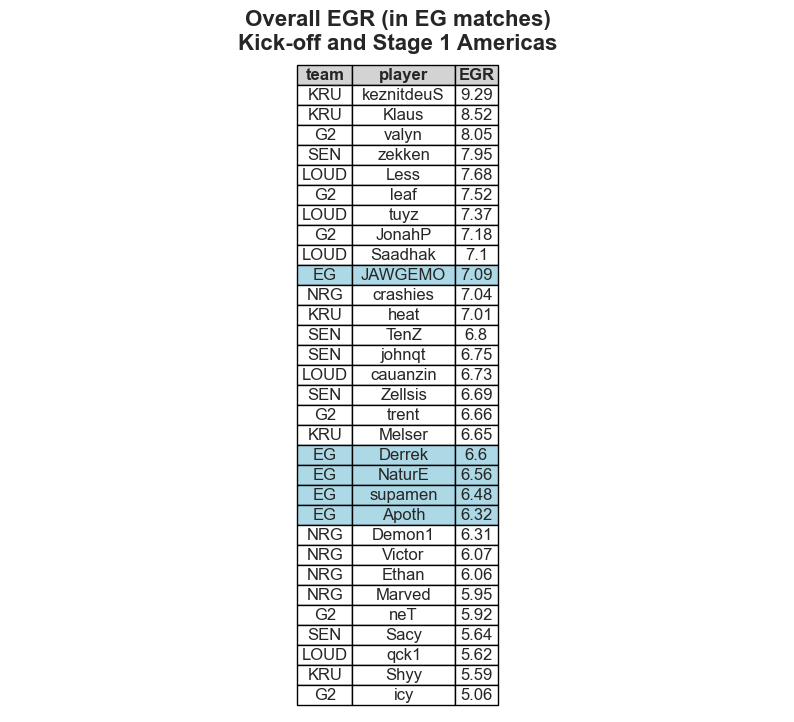

In [86]:
# Calculate the average EGR per game per player
average_egr_all = player_round_df.groupby(['game_id', 'team', 'player'])['EGR'].mean().reset_index()

# Calculate average EGR per player
overall_egr_per_player = average_egr_all.groupby(['team','player'])['EGR'].mean().reset_index()
overall_egr_per_player.sort_values('EGR', ascending=False, inplace=True)
overall_egr_per_player['EGR'] = overall_egr_per_player['EGR'].astype(float).round(2)

# Create a new figure with a defined size
fig, ax = plt.subplots(figsize=(10, 8.5))  # Adjust the size as needed

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create the table with the formatted data
the_table = ax.table(cellText=overall_egr_per_player.values,
                     colLabels=overall_egr_per_player.columns,
                     loc='center',
                     cellLoc='center')

# Adjust table styling
the_table.auto_set_font_size(True)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.2)  # Scale table size

# Optional: Enhance the style of the table
the_table.auto_set_column_width(col=list(range(len(overall_egr_per_player.columns))))  # Adjust column widths automatically

# Apply row coloring based on the team value
for (i, j), cell in the_table.get_celld().items():
    if i == 0:
        cell.set_fontsize(14)  # Bold for headers
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgray')  # Header background color
    else:
        if overall_egr_per_player.iloc[i-1]['team'] == 'EG':  # Check if the team is 'EG'
            cell.set_facecolor('lightblue')  # Highlight row in light blue
        else:
            cell.set_facecolor('white')  # Default color for other rows

plt.title('Overall EGR (in EG matches)\nKick-off and Stage 1 Americas', fontsize=16, weight='bold')

# Display the plot
plt.show()






#### Check some quick stats, including EGR, for specific game/round combinations

In [87]:
game_id = '9eb96458-82f2-4a25-b53c-c9bee13df754'
#game_id = '4a956e9a-4ace-4e0f-bc28-dba83e6d39ee'
eg_players = ['Apoth', 'Derrek', 'JAWGEMO', 'NaturE', 'supamen']
round_num = 21
dispdf = merged_table[(merged_table['game_id'] == game_id) & (merged_table['round_num'] == round_num)]
(dispdf.groupby('player').last().sort_values(by='EGR', ascending=False)).reset_index()[['player','round_num','kills','assists','deaths','our_team_alive', 'opponent_team_alive','is_alive','combat_score_round','EGR','won']]

,player,round_num,kills,assists,deaths,our_team_alive,opponent_team_alive,is_alive,combat_score_round,EGR,won
0,JonahP,21,16.0,5.0,12.0,2.0,0.0,1.0,1372.0,0.287972,True
1,supamen,21,18.0,8.0,13.0,0.0,2.0,0.0,865.0,0.188350,False
2,valyn,21,13.0,6.0,15.0,2.0,0.0,1.0,88.0,0.037809,True
3,trent,21,14.0,8.0,13.0,2.0,0.0,0.0,40.0,0.033324,True
4,Derrek,21,17.0,2.0,14.0,0.0,2.0,0.0,0.0,0.024023,False
5,leaf,21,18.0,2.0,13.0,2.0,0.0,0.0,0.0,0.023988,True
6,neT,21,8.0,2.0,16.0,2.0,0.0,0.0,0.0,0.023079,True
7,NaturE,21,8.0,12.0,14.0,0.0,2.0,0.0,0.0,0.020031,False
8,Apoth,21,14.0,2.0,13.0,0.0,2.0,0.0,0.0,0.019169,False
9,JAWGEMO,21,12.0,5.0,15.0,0.0,2.0,0.0,24.0,0.017295,False


In [88]:
feature_columns

Index(['ability1_base_charges', 'ability1_base_charges_change',
       'ability1_base_charges_gained', 'ability1_base_charges_used',
       'ability2_base_charges', 'ability2_base_charges_change',
       'ability2_base_charges_gained', 'ability2_base_charges_used',
       'agent_name', 'armor', 'damage_dealt_c', 'damage_taken_c', 'death_c',
       'death_change', 'grenade_base_charges', 'grenade_base_charges_change',
       'grenade_base_charges_gained', 'grenade_base_charges_used', 'hp',
       'inventory_value', 'is_alive', 'kill_c', 'kill_change', 'map_name',
       'opponent_damage_dealt_c', 'opponent_damage_taken_c',
       'opponent_death_c', 'opponent_kill_c', 'opponent_team_alive',
       'opponent_team_health', 'opponent_team_inventory_value',
       'our_team_alive', 'our_team_health', 'player_damage_dealt_c',
       'player_damage_taken_c', 'player_death_c', 'player_kill_c', 'round_num',
       'seconds', 'side', 'spike_event', 'spike_planted',
       'team_inventory_value',